In [0]:
import gym
import numpy as np
from IPython.display import clear_output
from time import sleep
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Globals
TRAINING_EPISODES = 50_000
SIM_EPISODES = 1_000
OPEN_AI_GYM_MODULE = 'Taxi-v3'
TRAINING_TYPES = ['random', 'q learning', 'q learning epsilon decay']

In [0]:
# For plotting purposes
label_font = {'size': 14}
tick_font = {'size': 14}

In [0]:
class taxi_cab():
  """A class that creates an autonomous taxicab with a training method."""
  
  def __init__(self, training_type='random'):
    self.env = gym.make(OPEN_AI_GYM_MODULE).env
    
    assert training_type in TRAINING_TYPES
    self.training_type = training_type

    # Animation metrics
    self.training_frames = []
    self.simulation_frames = []

    # Training evaluation metrics
    self.training_rewards_per_episode = []
    self.training_penalties_per_episode = []
    self.training_epochs_per_episode = []

    # Simulation evaluation metrics
    self.simulation_rewards_per_episode = []
    self.simulation_penalties_per_episode = []
    self.simulation_epochs_per_episode = []


  def epsilon_decay_function(self, i, epsilon, epsilon_decay):
    if i > 0 and self.training_type == 'q learning epsilon decay':
        epsilon = (epsilon * epsilon_decay)
    return epsilon


  def action_picker(self, state=None, epsilon=0):
    """Select the action given a state."""
    if self.training_type in TRAINING_TYPES[1:]:
      if random.uniform(0, 1) < epsilon:
        return self.env.action_space.sample()
      else:
        return np.argmax(self.q_table[state])
    else: # random training state
      return self.env.action_space.sample()


  def q_update(self, state, action, alpha, gamma, reward, next_state):
    """Q learning guts."""
    current_q = self.q_table[state, action]
    next_max_q = np.max(self.q_table[next_state])

    return ((1 - alpha) * current_q + alpha * (reward + gamma * next_max_q))
  

  def q_learning(
      self, 
      alpha=0.1, 
      gamma=0.6, 
      epsilon=0.3, 
      epsilon_decay = 1 - 0.01,  # 1% decay per run
      episodes=TRAINING_EPISODES,
      ):
    """Train the taxi car using q_learning."""
    print("Starting q learning training...")
    frames = []
    rewards_per_episode = []
    penalties_per_episode = []
    epochs_per_episode = []

    self.q_table = np.zeros([
      self.env.observation_space.n, 
      self.env.action_space.n,
      ])

    for i in range(0, episodes+1):
      state = self.env.reset()
      epochs, penalties, rewards, reward = 0, 0, 0, 0
      done = False

      epsilon = self.epsilon_decay_function(i, epsilon, epsilon_decay)      

      while not done:
        action = self.action_picker(state=state, epsilon=epsilon)
        next_state, reward, done, info = self.env.step(action)
        q_value = self.q_update(
            state, action, alpha, gamma, reward, next_state
            )
        self.q_table[state, action] = q_value
        
        if reward == -10:
          penalties += 1

        # metrics @ every epoch for animations
        frames.append({
          'frame': self.env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward,
          }
        )
        
        state = next_state
        epochs += 1
        rewards += reward

      rewards_per_episode.append(rewards) 
      penalties_per_episode.append(penalties)
      epochs_per_episode.append(epochs) 

      if i % 100 == 0:
        clear_output(wait=True)
        print(f'Episode: {i}')

    self.training_frames = frames
    self.training_rewards_per_episode = rewards_per_episode
    self.training_penalties_per_episode = penalties_per_episode
    self.training_epochs_per_episode = epochs_per_episode
      
    print("Done q learning training")

  
  def simulate_taxi_runs(self, episodes=SIM_EPISODES):
    """Simulate taxi runs after trainig has taken place."""
    print('Starting taxi simulation...')
    total_epochs, total_penalties = 0, 0

    frames = []
    rewards_per_episode = []
    penalties_per_episode = []
    epochs_per_episode = []

    for i in range(episodes+1): 
      state = self.env.reset()
      epochs, penalties, rewards, reward = 0, 0, 0, 0

      done = False

      while not done:
        action = self.action_picker(state=state)
        state, reward, done, info = self.env.step(action)
        
        if reward == -10:
          penalties += 1
        
        # metrics @ every epoch for animations
        frames.append({
          'frame': self.env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward,
          }
        )

        epochs += 1
        rewards += reward

      rewards_per_episode.append(rewards) 
      penalties_per_episode.append(penalties)
      epochs_per_episode.append(epochs)       
      
      total_epochs += epochs
      total_penalties += penalties

      if i % 100 == 0:
        clear_output(wait=True)
        print(f'Simulation episode: {i}')

    self.simulation_frames = frames
    self.simulation_rewards_per_episode = rewards_per_episode
    self.simulation_penalties_per_episode = penalties_per_episode
    self.simulation_epochs_per_episode = epochs_per_episode

    print(f"Simulation complete.  Results after {episodes} episodes:")
    print(f"\tAverage timesteps per episode: {total_epochs / episodes}")
    print(f"\tAverage penalties per episode: {total_penalties / episodes}")


  def animate_taxi_runs(self, animation_type='simulation'):
    """Animate the taxi runs by using data stored in frames."""
    if animation_type == 'simulation':
      frames = self.simulation_frames
    else:
      frames = self.training_frames

    for i, frame in enumerate(frames[:100]): # only animate 100 frames for time
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

In [5]:
naive_taxi = taxi_cab()
naive_taxi.simulate_taxi_runs()

Simulation episode: 1000
Simulation complete.  Results after 1000 episodes:
	Average timesteps per episode: 2461.748
	Average penalties per episode: 796.964


In [6]:
naive_taxi.animate_taxi_runs()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 100
State: 108
Action: 0
Reward: -1


In [7]:
%%time
q_taxi = taxi_cab(training_type='q learning')
q_taxi.q_learning()

Episode: 50000
Done q learning training
CPU times: user 1min 25s, sys: 5.64 s, total: 1min 31s
Wall time: 1min 24s


In [8]:
q_taxi.simulate_taxi_runs()

Simulation episode: 1000
Simulation complete.  Results after 1000 episodes:
	Average timesteps per episode: 13.043
	Average penalties per episode: 0.0


In [9]:
q_taxi.animate_taxi_runs(animation_type='training')

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 100
State: 198
Action: 3
Reward: -1


In [10]:
q_taxi.animate_taxi_runs(animation_type='simulation')

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 100
State: 237
Action: 2
Reward: -1


In [11]:
%%time
q_taxi_epsilon_decay = taxi_cab(training_type='q learning epsilon decay')
q_taxi_epsilon_decay.q_learning(epsilon=1)

Episode: 50000
Done q learning training
CPU times: user 1min 3s, sys: 6.67 s, total: 1min 9s
Wall time: 1min 2s


In [12]:
q_taxi_epsilon_decay.simulate_taxi_runs()

Simulation episode: 1000
Simulation complete.  Results after 1000 episodes:
	Average timesteps per episode: 13.094
	Average penalties per episode: 0.0


In [0]:
def plot_overlayed(
    dat1, 
    dat2, 
    title, 
    x_axis='Episode No.',
    leg1='Epsilon Greedy',
    leg2='Epsilon Greedy Decay',
    ymin=0,
    ymax=150,
    ylabel='timesteps/episode',
    xlabel='episode no./100'
    ):
  
    fig, ax1 = plt.subplots(figsize=(15, 5))
    plt.title(title,fontdict=label_font)
    plt.plot(dat1, color='orange', linewidth=2, alpha=0.6)
    ax1.set_ylim([ymin,ymax])
    ax1.set_ylabel(ylabel,fontdict=label_font)
    ax1.set_xlabel(xlabel,fontdict=label_font)
    plt.legend([leg1], loc=1)
    ax2 = ax1.twinx()
    plt.plot(dat2, color='grey', linewidth=2)
    ax2.set_ylim([ymin,ymax])
    plt.legend([leg2], loc=2)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(title + ".png")

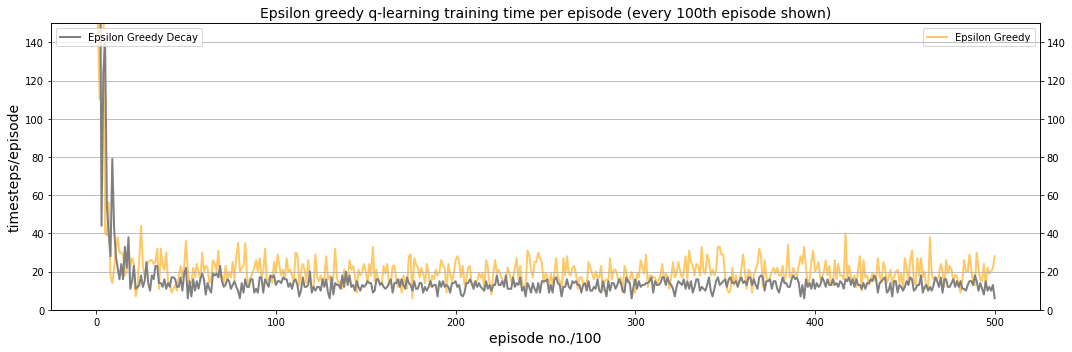

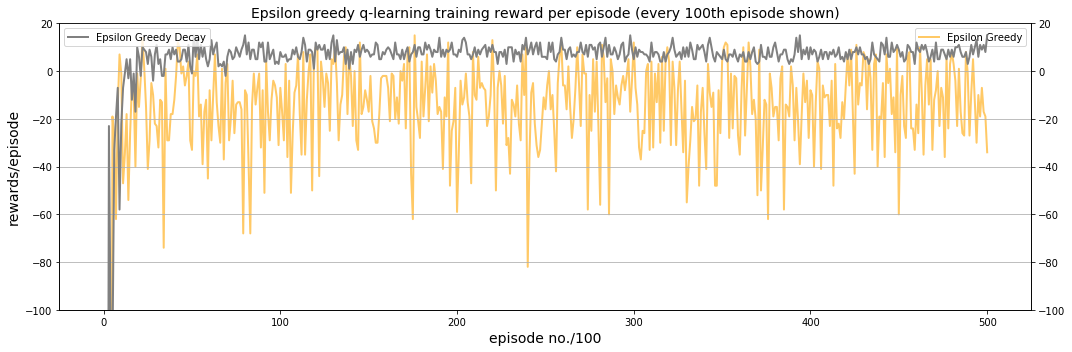

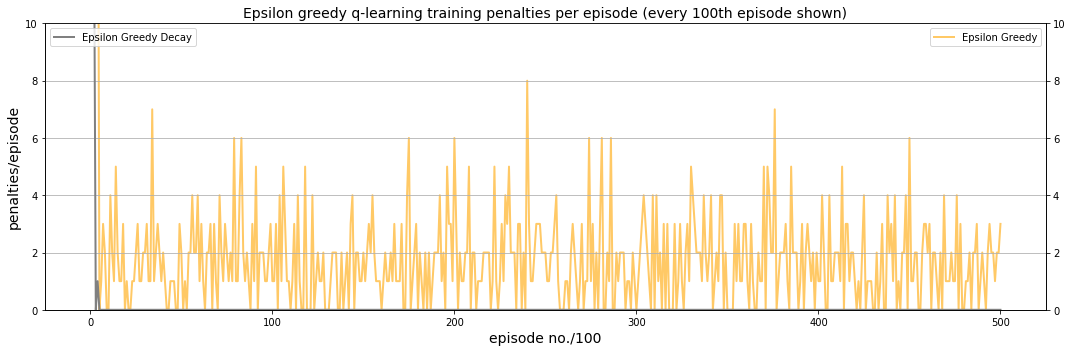

In [16]:
plot_overlayed(
      q_taxi.training_epochs_per_episode[0::100],
      q_taxi_epsilon_decay.training_epochs_per_episode[0::100],
      title="Epsilon greedy q-learning training time per episode (every 100th episode shown)",
      ylabel='timesteps/episode',
  )
plot_overlayed(
      q_taxi.training_rewards_per_episode[0::100],
      q_taxi_epsilon_decay.training_rewards_per_episode[0::100],
      title="Epsilon greedy q-learning training reward per episode (every 100th episode shown)",
      ymin=-100, 
      ymax=20,
      ylabel='rewards/episode',
  )
plot_overlayed(
      q_taxi.training_penalties_per_episode[0::100],
      q_taxi_epsilon_decay.training_penalties_per_episode[0::100],
      title="Epsilon greedy q-learning training penalties per episode (every 100th episode shown)",
      ylabel='penalties/episode',
      ymax=10,
  )